In [1]:
import pandas as pd
import io
import re
from pathlib import Path
import numpy as np
import requests
import numpy as np
from datetime import datetime, timedelta
import math
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [2]:
# ── Helpers ───────────────────────────────────────────────────────────
def parse_hurdat2(text: str) -> pd.DataFrame:
    """
    Parse Atlantic HURDAT2 into tidy six-hourly records.
    Columns: ['storm_id','storm_name','iso_time','year','lat','lon','status','max_wind_kt','min_mslp_mb']
    """
    lines = [ln.strip() for ln in text.splitlines() if ln.strip()]
    rows = []
    i = 0
    while i < len(lines):
        m = re.match(r'^([A-Z]{2}\d{6}),\s*([^,]+),\s*(\d+)', lines[i])
        if not m:
            i += 1
            continue
        storm_id, storm_name, n = m.group(1), m.group(2).strip(), int(m.group(3))
        i += 1
        for _ in range(n):
            parts = [p.strip() for p in lines[i].split(",")]
            ymd, hm = parts[0], parts[1]
            status  = parts[3] if len(parts) > 3 else ""
            lat_s   = parts[4] if len(parts) > 4 else ""
            lon_s   = parts[5] if len(parts) > 5 else ""
            wind_s  = parts[6] if len(parts) > 6 else ""
            mslp_s  = parts[7] if len(parts) > 7 else ""

            t = datetime.strptime(ymd + hm, "%Y%m%d%H%M")

            def parse_ll(s, neg=("S","W")):
                s = s.upper()
                if s and s[-1] in ("N","S","E","W"):
                    sign = -1 if s[-1] in neg else 1
                    return sign * float(s[:-1])
                return float(s) if s else None

            def to_int(x):
                try: return int(x)
                except: return None

            rows.append({
                "storm_id":     storm_id,
                "storm_name":   storm_name,
                "iso_time":     t,
                "year":         t.year,
                "lat":          parse_ll(lat_s),
                "lon":          parse_ll(lon_s),
                "status":       status,       # TD/TS/HU/SS/SD/EX/LO/DB, etc.
                "max_wind_kt":  to_int(wind_s),
                "min_mslp_mb":  to_int(mslp_s),
            })
            i += 1
    df = pd.DataFrame(rows)
    # Keep only fixes with coords/time
    return df.dropna(subset=["iso_time","lat","lon"]).reset_index(drop=True)

In [3]:
def haversine_km(lat1, lon1, lat2, lon2):
    """Vectorized haversine distance (km)."""
    R = 6371.0088
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*(np.sin(dlon/2.0)**2)
    c = 2*np.arcsin(np.sqrt(a))
    return R * c

In [4]:
# ── Helper: build “closest-track” pseudo-labels for a cluster ────────
def seed_labels_by_closest_fix(msub, speed_kmh=30.0):
    """
    msub: matches for ONE cluster_id (each row is a (claim x fix) pair)
          must have: ['dateOfLoss','claim_lat','claim_lon','storm_id',
                      'time_delta_hours','distance_km']
    """
    s = msub.copy()
    # Build a per-claim key
    s["claim_key"] = list(zip(
        s["dateOfLoss"].values,
        s["claim_lat"].round(5).values,
        s["claim_lon"].round(5).values
    ))
    # Space–time score in km (time converted via speed)
    s["score"] = s["distance_km"] + np.abs(s["time_delta_hours"]) * speed_kmh
    idx = s.groupby("claim_key")["score"].idxmin()
    best = s.loc[idx, ["claim_key","storm_id"]].set_index("claim_key")["storm_id"]
    return best

In [5]:
# ── Helper: make features (x,y,t) in projected coords + scaled time ──
def make_features(claims_sub, speed_kmh=30.0):
    gdf = gpd.GeoDataFrame(
        claims_sub,
        geometry=gpd.points_from_xy(claims_sub["longitude"], claims_sub["latitude"]),
        crs=CRS_LL
    ).to_crs(CRS_EQD)

    x_km = gdf.geometry.x.values / 1000.0
    y_km = gdf.geometry.y.values / 1000.0
    t0 = claims_sub["dateOfLoss"].median()
    t_h = (claims_sub["dateOfLoss"] - t0).dt.total_seconds().values / 3600.0
    t_km = t_h * speed_kmh

    X = pd.DataFrame({"x_km": x_km, "y_km": y_km, "t_km": t_km})
    return X, gdf

# Parameters

In [6]:
optimal_cluster = 'st_cluster_final_gid'  # or 'st_cluster_3_5_7', etc.
R_KM     = 50.0       # spatial radius for intersection
T_HOURS  = 72.0       # temporal window (± hours) for intersection
URL = "https://www.nhc.noaa.gov/data/hurdat/hurdat2-1851-2024-040425.txt"
EXCLUDE_CLUSTER = -1                       # do not split this label
TIME_SCALE_H = 24.0                        # rescales time (hours) relative to space
CRS_LL = "EPSG:4326"                       # lat/lon
CRS_EQD = "EPSG:5070"                      # equal-area / good for US (or use 3857)
POINT_SIZE = 10

# Load Basemaps

In [7]:
# ── 2) Load basemaps (counties/states/rivers) if available ──────────
try:
    shapefile_path = '../Local_Data/Geospatial/tl_2019_us_county.shp'
    gdf_counties = gpd.read_file(shapefile_path).to_crs(CRS_EQD)
except Exception:
    gdf_counties = None

try:
    state_shapefile_path = '../Local_Data/Geospatial/cb_2018_us_state_20m.shp'
    gdf_states = gpd.read_file(state_shapefile_path).to_crs(CRS_EQD)
except Exception:
    gdf_states = None

# Load Clusters

In [8]:
# ── 1) Load your clustered claims ─────────────────────────────────────
clustered_claims = pd.read_csv("../2_Low_Return_Period/new_clusters_9.24.25.csv")

# Ensure county FIPS formatting and datetime
clustered_claims['countyCode'] = clustered_claims['countyCode'].astype(int).astype(str).str.zfill(5)
clustered_claims['dateOfLoss'] = pd.to_datetime(clustered_claims['dateOfLoss']).dt.tz_localize(None)

# We only need these columns for intersection logic
claims = (clustered_claims
          [[optimal_cluster, "dateOfLoss", "latitude", "longitude"]]
          .dropna(subset=[optimal_cluster, "dateOfLoss", "latitude", "longitude"])
          .rename(columns={
              optimal_cluster: "cluster_id",
              "latitude": "claim_lat",
              "longitude": "claim_lon"
          })
          .copy())
claims["date_floor"] = claims["dateOfLoss"].dt.floor("D")

/tmp/ipykernel_163/1440155364.py:2: DtypeWarning: Columns (7,51,66) have mixed types. Specify dtype option on import or set low_memory=False.
  clustered_claims = pd.read_csv("../2_Low_Return_Period/new_clusters_9.24.25.csv")


# Load Hurricane Tracks

In [9]:
# ── 2) Load & tidy HURDAT2 tracks ─────────────────────────────────────
resp = requests.get(URL, timeout=60)
resp.raise_for_status()
hurdat = parse_hurdat2(resp.text)

tracks = (hurdat[["storm_id","storm_name","iso_time","year","lat","lon"]]
          .dropna()
          .copy())
tracks["date_floor"] = pd.to_datetime(tracks["iso_time"]).dt.floor("D")

In [10]:
# ── 3) Space–time matching: ±T_HOURS & within R_KM ────────────────────
# To capture *all* potential claim–fix pairs in a ±3-day window without a heavy cross-join,
# align on floor(date) with integer day offsets, then filter by exact |Δt| and distance.
matches = []
for day_offset in range(-int(T_HOURS//24)-1, int(T_HOURS//24)+2):
    ctmp = claims.copy()
    ctmp["date_shifted"] = ctmp["date_floor"] + pd.Timedelta(days=day_offset)
    merged = tracks.merge(
        ctmp,
        left_on="date_floor",
        right_on="date_shifted",
        how="inner",
        suffixes=("", "_c")
    )
    if merged.empty:
        continue

    # Compute exact time and distance deltas
    dt_hours = (merged["iso_time"] - merged["dateOfLoss"]).abs().dt.total_seconds() / 3600.0
    dist_km  = haversine_km(merged["lat"], merged["lon"], merged["claim_lat"], merged["claim_lon"])

    keep = (dt_hours <= T_HOURS) & (dist_km <= R_KM)
    if keep.any():
        m = merged.loc[keep, [
            "storm_id","storm_name","iso_time","year","lat","lon",
            "cluster_id","dateOfLoss","claim_lat","claim_lon"
        ]].copy()
        m["time_delta_hours"] = dt_hours[keep].values
        m["distance_km"]      = dist_km[keep].values
        matches.append(m)

matches = pd.concat(matches, ignore_index=True) if matches else pd.DataFrame(
    columns=["storm_id","storm_name","iso_time","year","lat","lon",
             "cluster_id","dateOfLoss","claim_lat","claim_lon",
             "time_delta_hours","distance_km"]
)

# Deduplicate at the (fix,claim) level in case multiple offsets hit
matches.drop_duplicates(
    subset=["storm_id","iso_time","cluster_id","dateOfLoss","claim_lat","claim_lon"],
    inplace=True
)

In [11]:
# ── 4)  Print total number of tracks + per-year that intersect clusters ───────
# A "track" here = a unique storm_id with ≥1 intersecting fix.
tracks_intersecting = matches[["storm_id"]].drop_duplicates()
n_tracks_total = len(tracks_intersecting)

per_year_tracks = (matches[["year","storm_id"]]
                   .drop_duplicates()
                   .groupby("year")["storm_id"]
                   .nunique()
                   .sort_index())

print(f"Total hurricane tracks intersecting claim clusters (R≤{R_KM} km, |Δt|≤{T_HOURS} h): {n_tracks_total}")
print("\nTracks per year (unique storm_ids with ≥1 intersection):")
print(per_year_tracks.to_string())

Total hurricane tracks intersecting claim clusters (R≤50.0 km, |Δt|≤72.0 h): 181

Tracks per year (unique storm_ids with ≥1 intersection):
year
1978     2
1979     5
1980     3
1981     3
1982     2
1983     1
1984     3
1985     7
1986     2
1987     2
1988     5
1989     4
1990     1
1991     2
1992     2
1993     1
1994     4
1995     5
1996     3
1997     1
1998     7
1999     5
2000     2
2001     3
2002     8
2003     6
2004     9
2005     9
2006     2
2007     4
2008     6
2009     1
2010     4
2011     2
2012     4
2013     1
2014     1
2015     2
2016     4
2017     5
2018     4
2019     4
2020    12
2021     7
2022     4
2023     2
2024     5


In [12]:
# ── 5)  Extract subset of tracks and clusters that intersect ───────────────────
intersecting_storm_ids = set(tracks_intersecting["storm_id"])
intersecting_cluster_ids = set(matches["cluster_id"].unique())

tracks_subset = hurdat[hurdat["storm_id"].isin(intersecting_storm_ids)].copy()
clusters_subset = clustered_claims[clustered_claims[optimal_cluster].isin(intersecting_cluster_ids)].copy()

print(f"\nSubset sizes → track fixes: {len(tracks_subset):,} | clusters' claim rows: {len(clusters_subset):,}")
print(f"Distinct storms in subset: {len(intersecting_storm_ids)} | Distinct clusters in subset: {len(intersecting_cluster_ids)}")


Subset sizes → track fixes: 6,205 | clusters' claim rows: 1,178,837
Distinct storms in subset: 181 | Distinct clusters in subset: 184


In [13]:
# ── 6)  Clusters that contain multiple distinct tracks ─────────────────────────
tracks_per_cluster = (matches.groupby("cluster_id")["storm_id"]
                      .nunique()
                      .reset_index(name="n_tracks"))
multi_track_clusters = tracks_per_cluster.loc[tracks_per_cluster["n_tracks"] >= 2]
n_multi = len(multi_track_clusters)

print(f"\nTotal clusters containing ≥2 distinct tracks: {n_multi}")
# Optional: show top examples
if n_multi > 0:
    print("\nSample clusters with multiple tracks (cluster_id, n_tracks):")
    print(multi_track_clusters.sort_values("n_tracks", ascending=False).head(20).to_string(index=False))

# ── Optional: keep artifacts for downstream use ────────────────────────────────
# matches: row-per (intersecting fix x claim) with time & distance diagnostics
# tracks_subset: all fixes for storms that intersected
# clusters_subset: all claim rows in clusters that intersected
# tracks_per_cluster: number of distinct storms per cluster



Total clusters containing ≥2 distinct tracks: 23

Sample clusters with multiple tracks (cluster_id, n_tracks):
 cluster_id  n_tracks
         -1        30
       1676         8
       1355         4
       1289         3
       1667         3
       1545         3
       1074         3
       2865         3
       2871         3
        119         2
        539         2
       1288         2
       1739         2
       1734         2
       1716         2
       1927         2
       1923         2
       2519         2
       2653         2
       2813         2


In [14]:
# ── 0) Precompute: clusters with ≥2 tracks (excluding -1) ────────────
# Expect 'matches' from the previous step; if not present, raise an error.
if "matches" not in globals():
    raise RuntimeError("`matches` DataFrame not found. Run the intersection step first.")

# Filter to valid clusters
valid_matches = matches[matches["cluster_id"] != EXCLUDE_CLUSTER].copy()

tracks_per_cluster = (valid_matches.groupby("cluster_id")["storm_id"]
                      .nunique()
                      .reset_index(name="n_tracks"))

multi_track_clusters = tracks_per_cluster.loc[tracks_per_cluster["n_tracks"] >= 2, "cluster_id"].tolist()
print(f"Clusters to split (≥2 tracks, excluding {EXCLUDE_CLUSTER}): {len(multi_track_clusters)}")

Clusters to split (≥2 tracks, excluding -1): 22


In [15]:
# Prepare line geometries for tracks (for plotting) ─────────────
# Build per-storm LineStrings over North America extent
hurdat_ll = gpd.GeoDataFrame(
    hurdat[["storm_id","storm_name","iso_time","lat","lon"]].dropna(),
    geometry=gpd.points_from_xy(hurdat["lon"], hurdat["lat"]),
    crs=CRS_LL
)

# 1) Ensure hurdat_ll really has a CRS
if getattr(hurdat_ll, "crs", None) is None:
    hurdat_ll = hurdat_ll.set_crs(CRS_LL, allow_override=True)

# 2) Sort by time and aggregate points -> LineString
lines_df = (
    hurdat_ll.sort_values(["storm_id", "iso_time"])
             .groupby("storm_id")
             .agg(geometry=("geometry", lambda s: LineString([pt for pt in s.tolist()]) if len(s) > 1 else None))
             .dropna(subset=["geometry"])
             .reset_index()
)

# 3) Wrap as a proper GeoDataFrame with explicit geometry column + CRS
gdf_tracks = gpd.GeoDataFrame(lines_df, geometry="geometry", crs=hurdat_ll.crs)

# 4) Now safely project
gdf_tracks = gdf_tracks.to_crs(CRS_EQD)

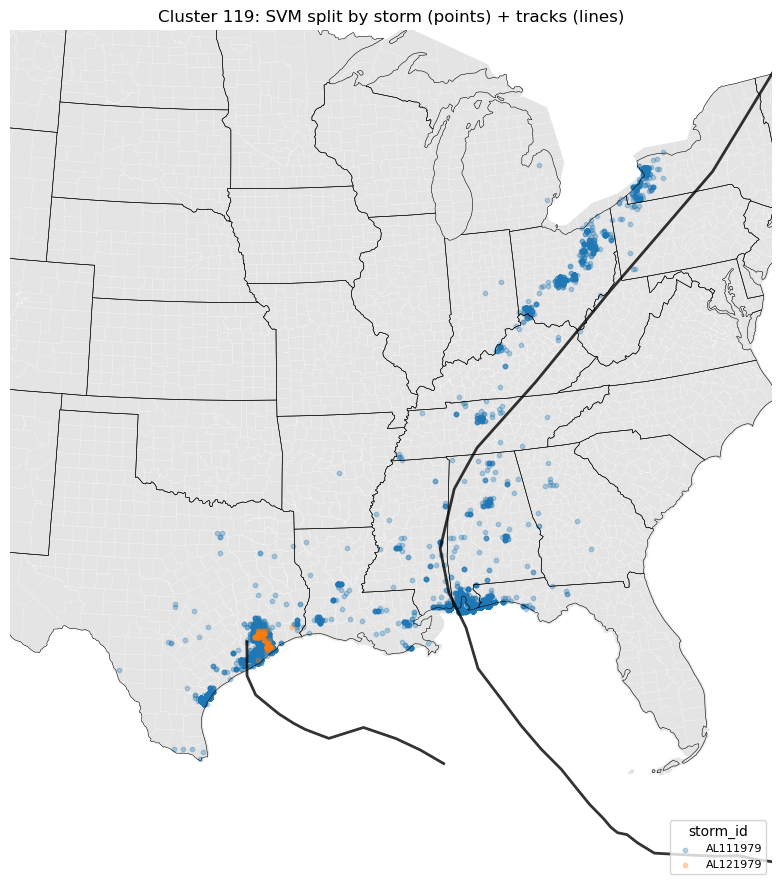

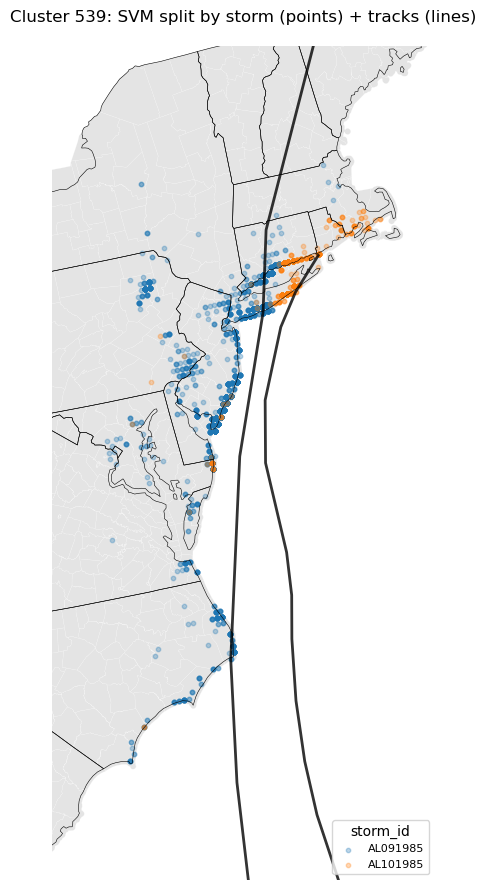

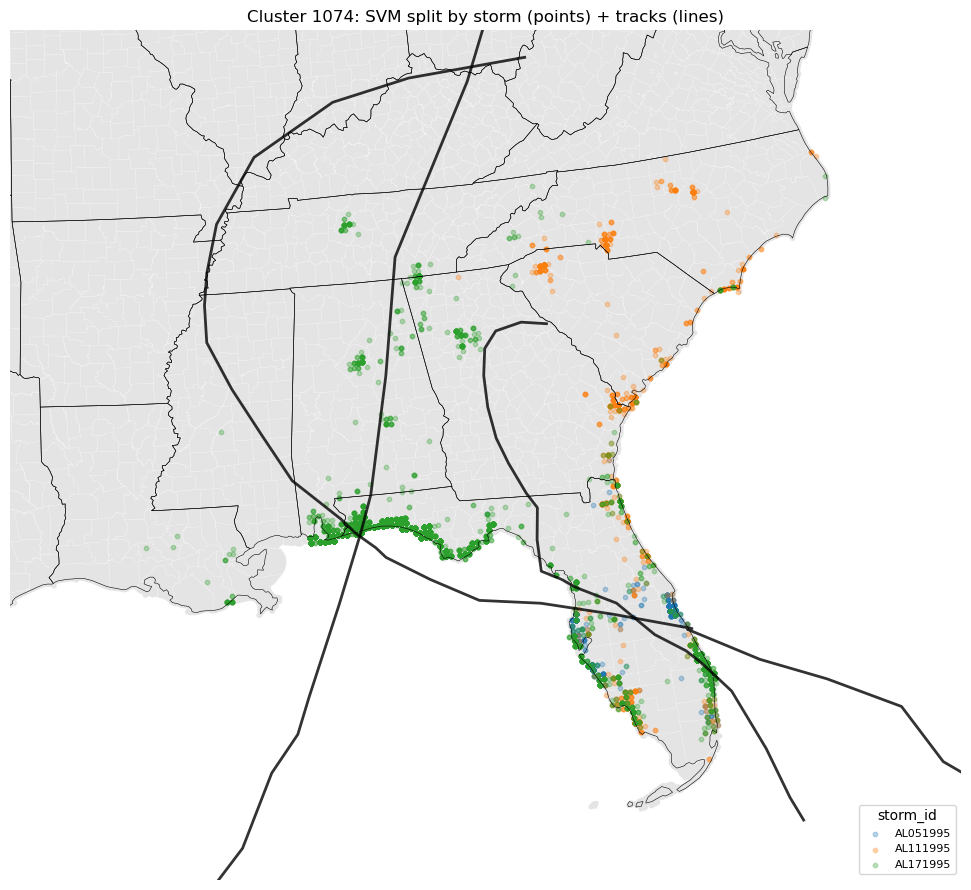

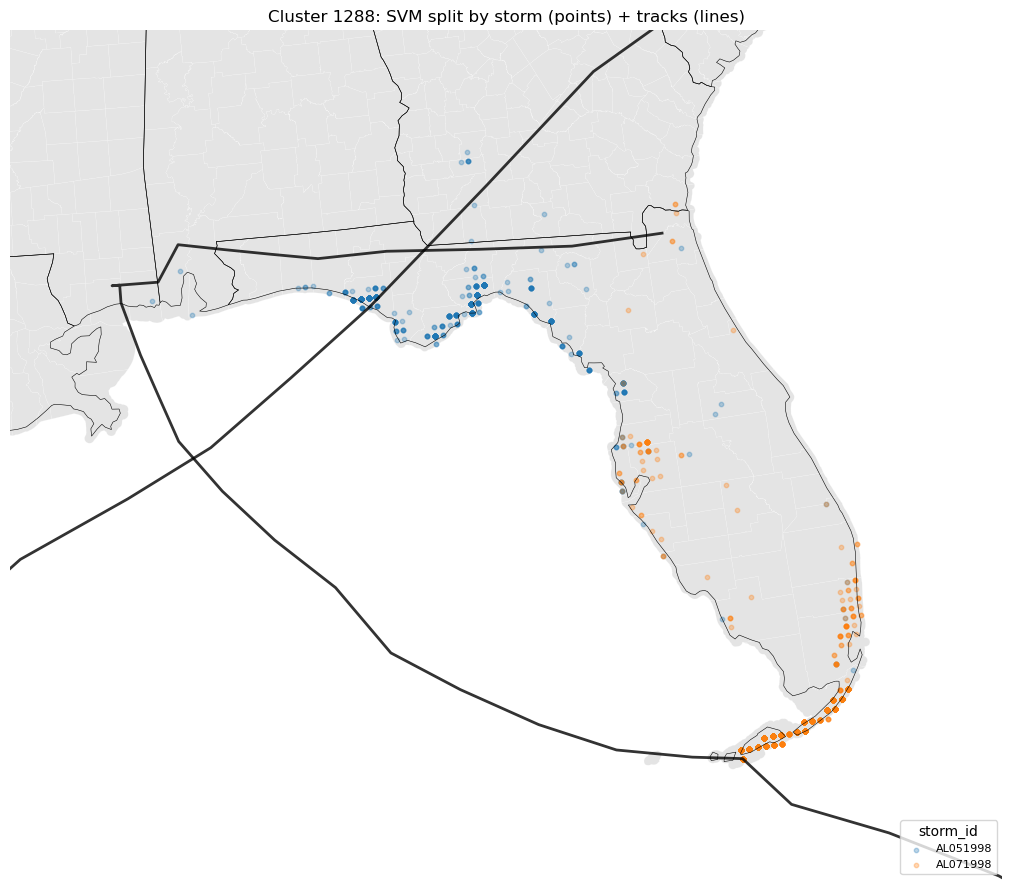

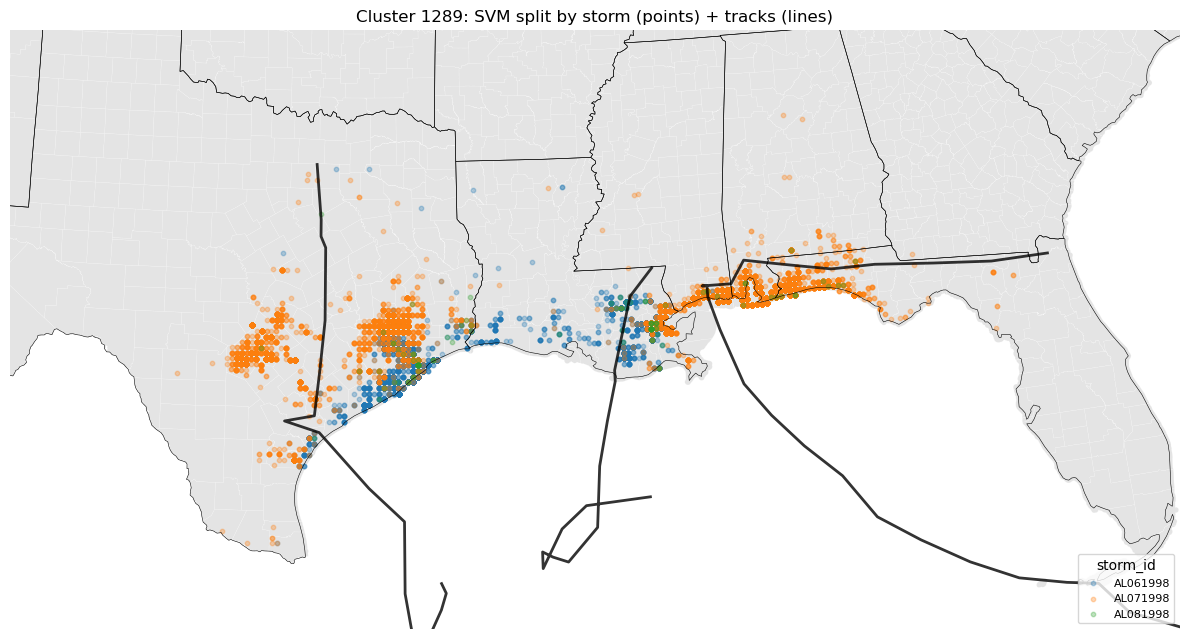

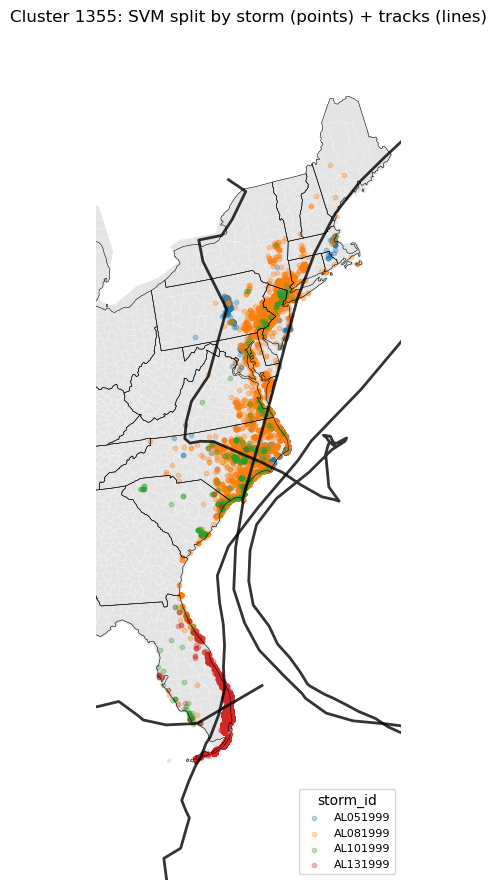

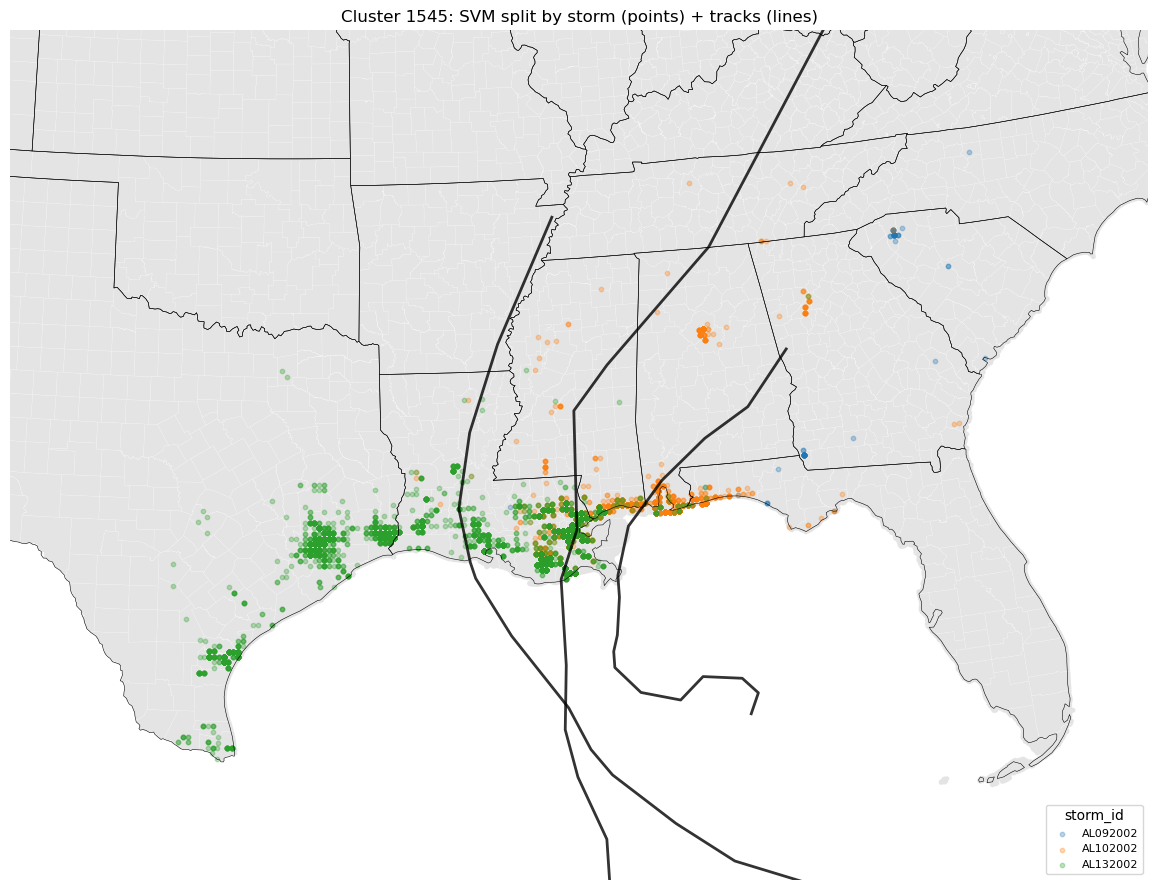

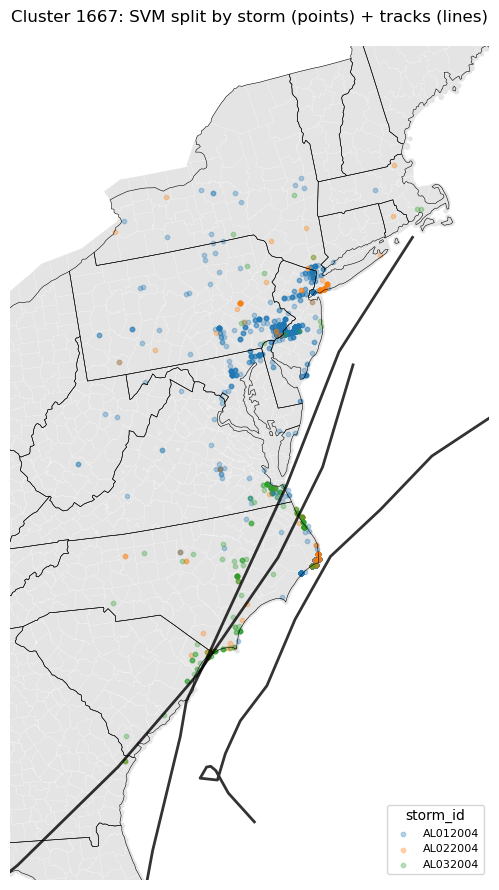

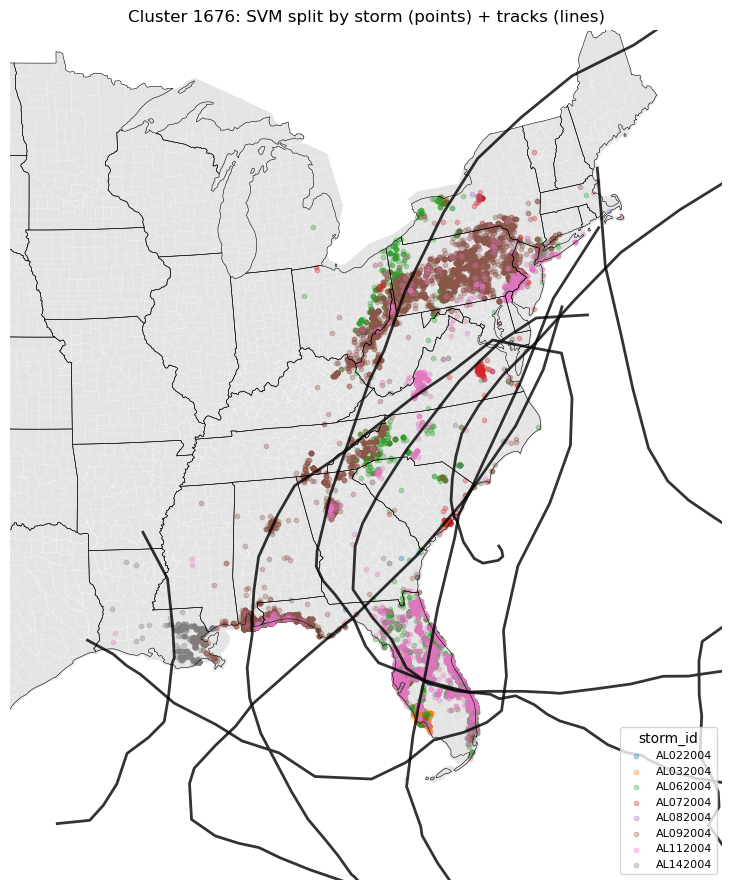

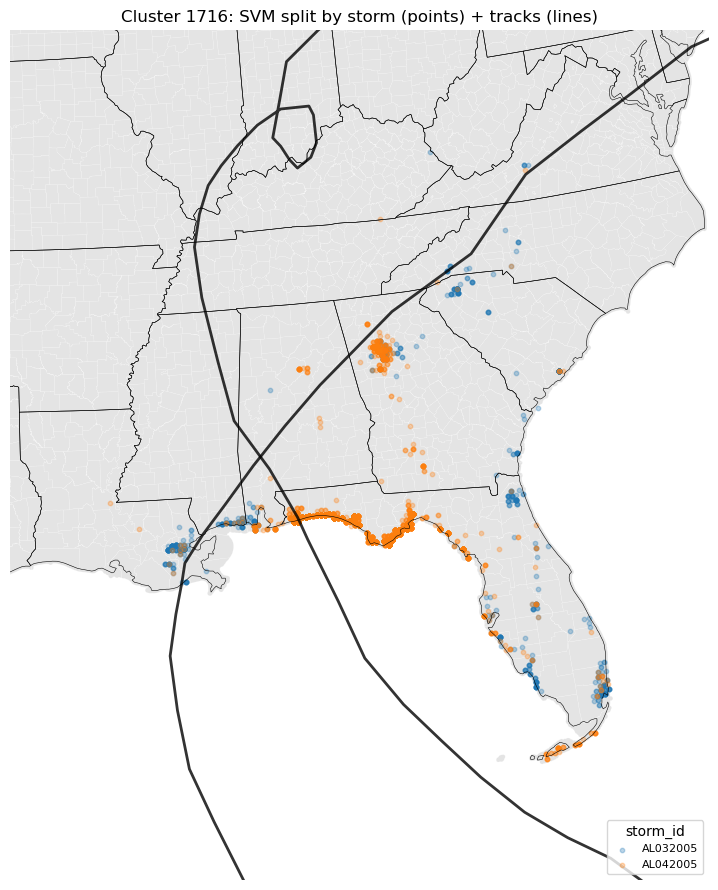

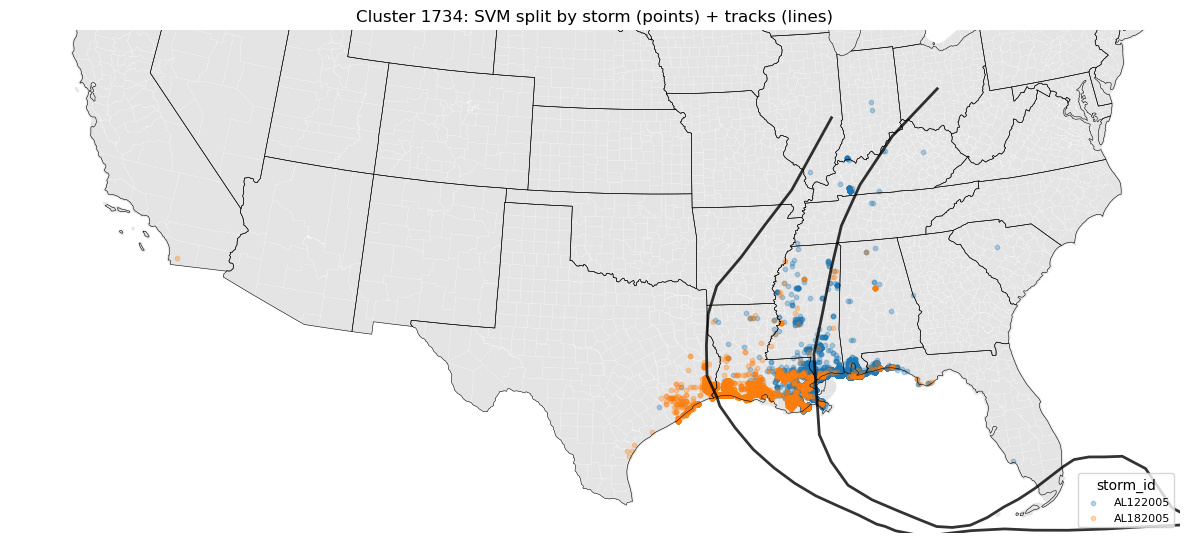

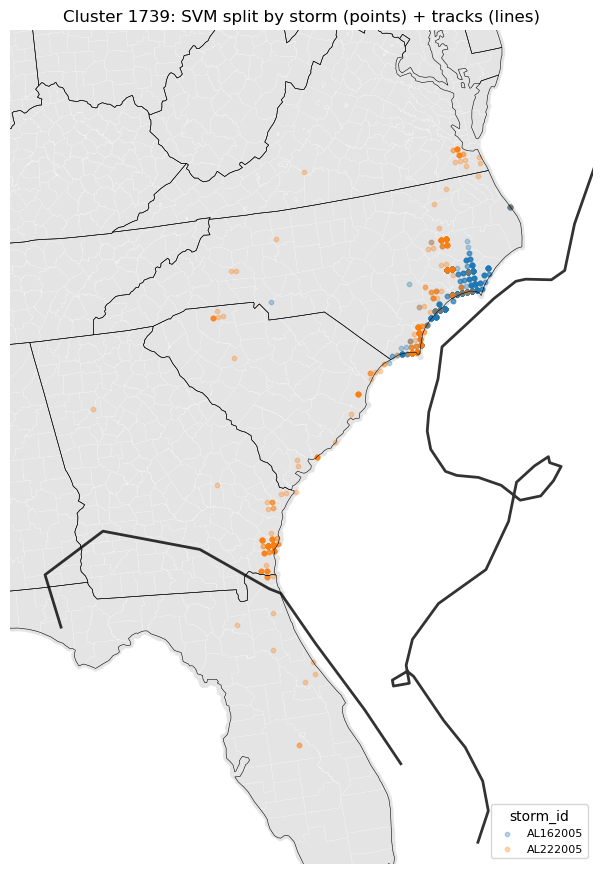

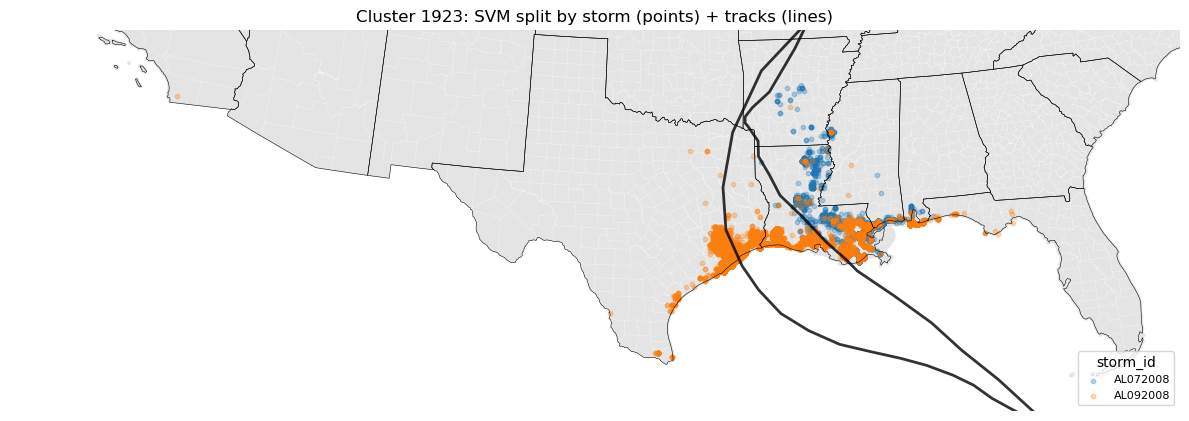

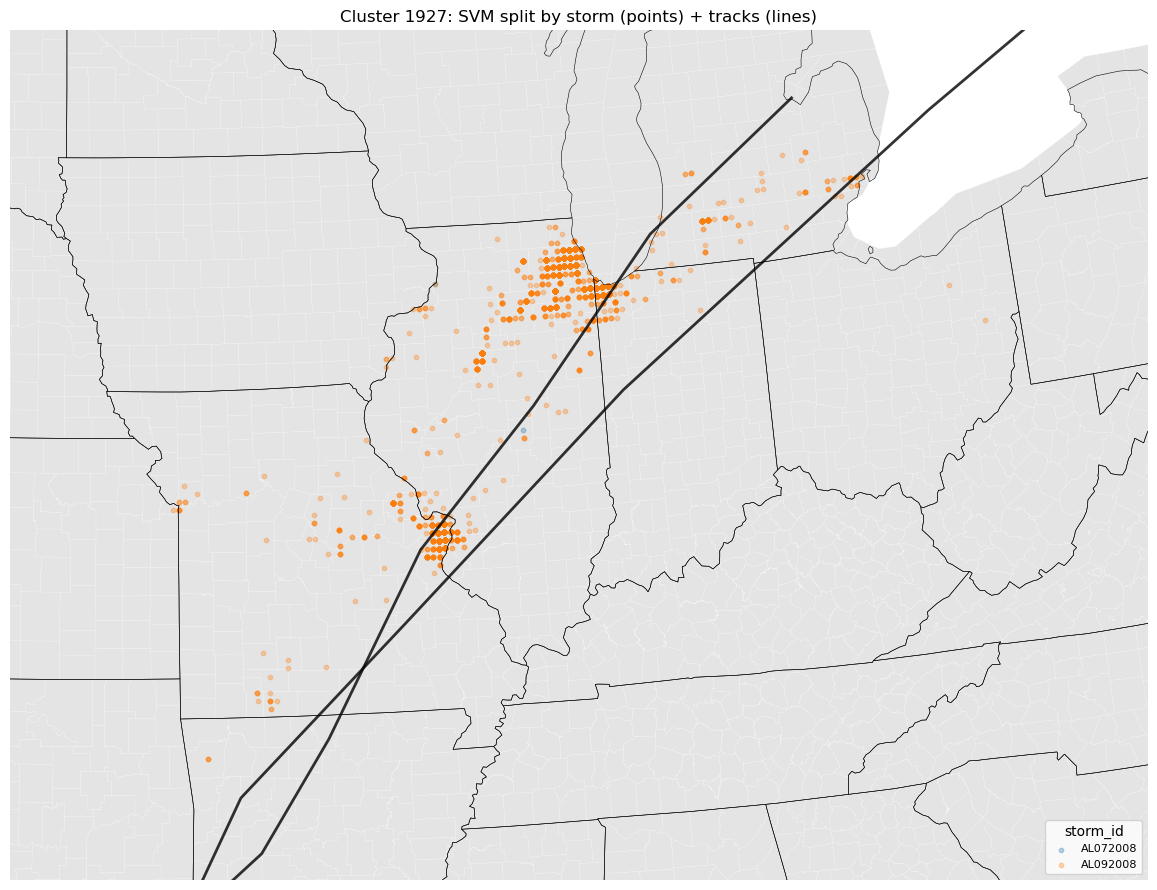

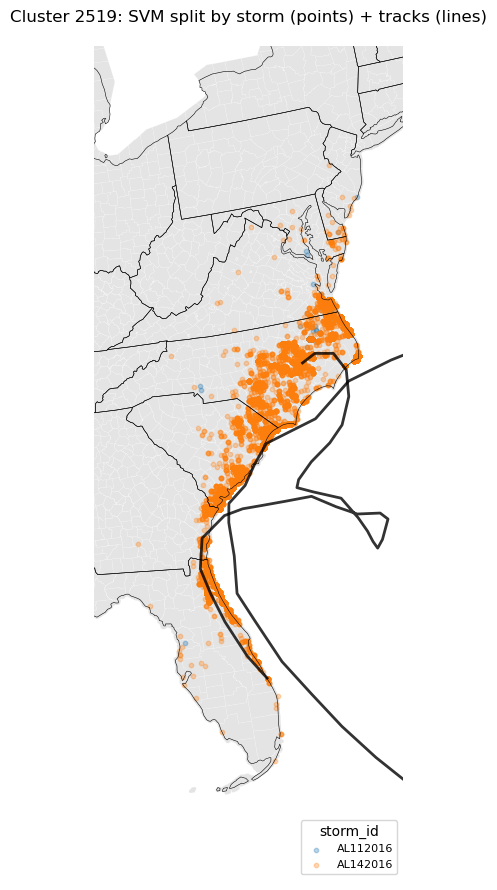

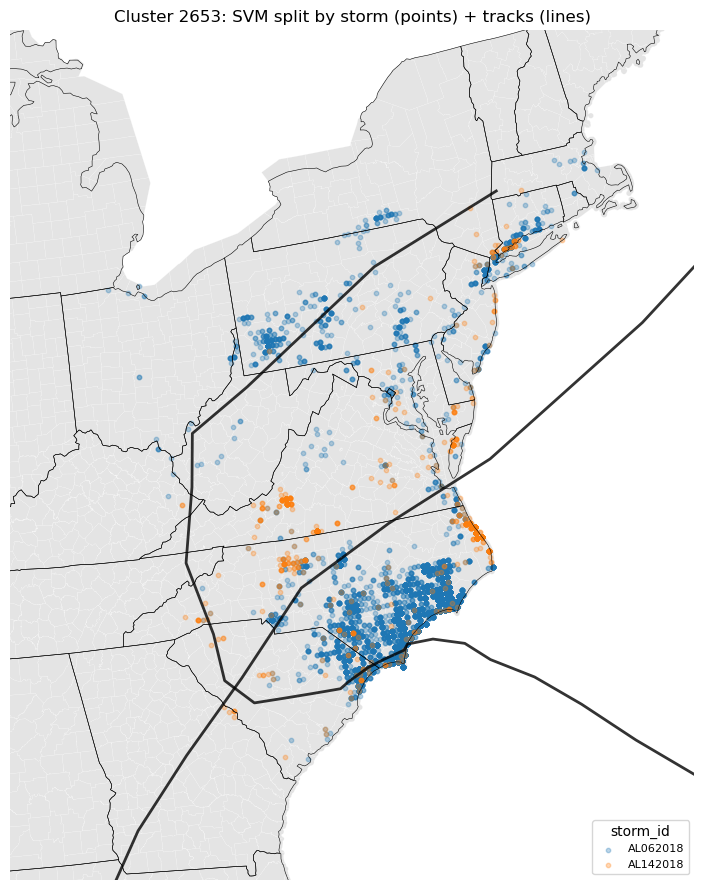

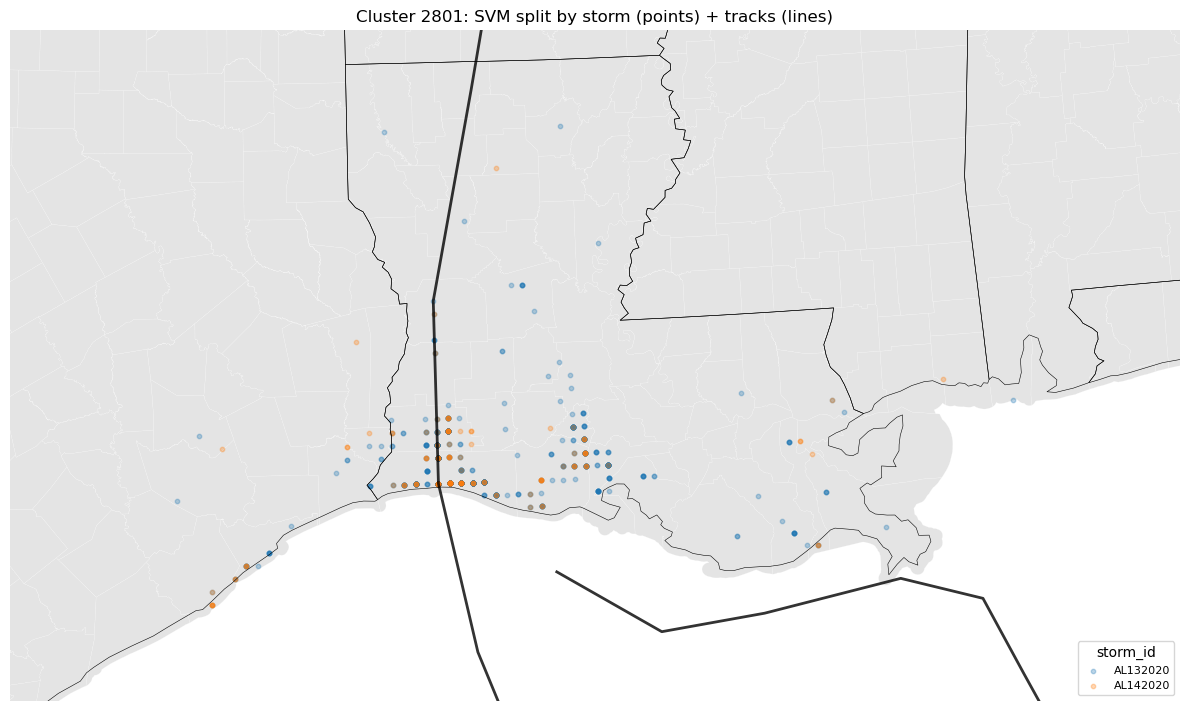

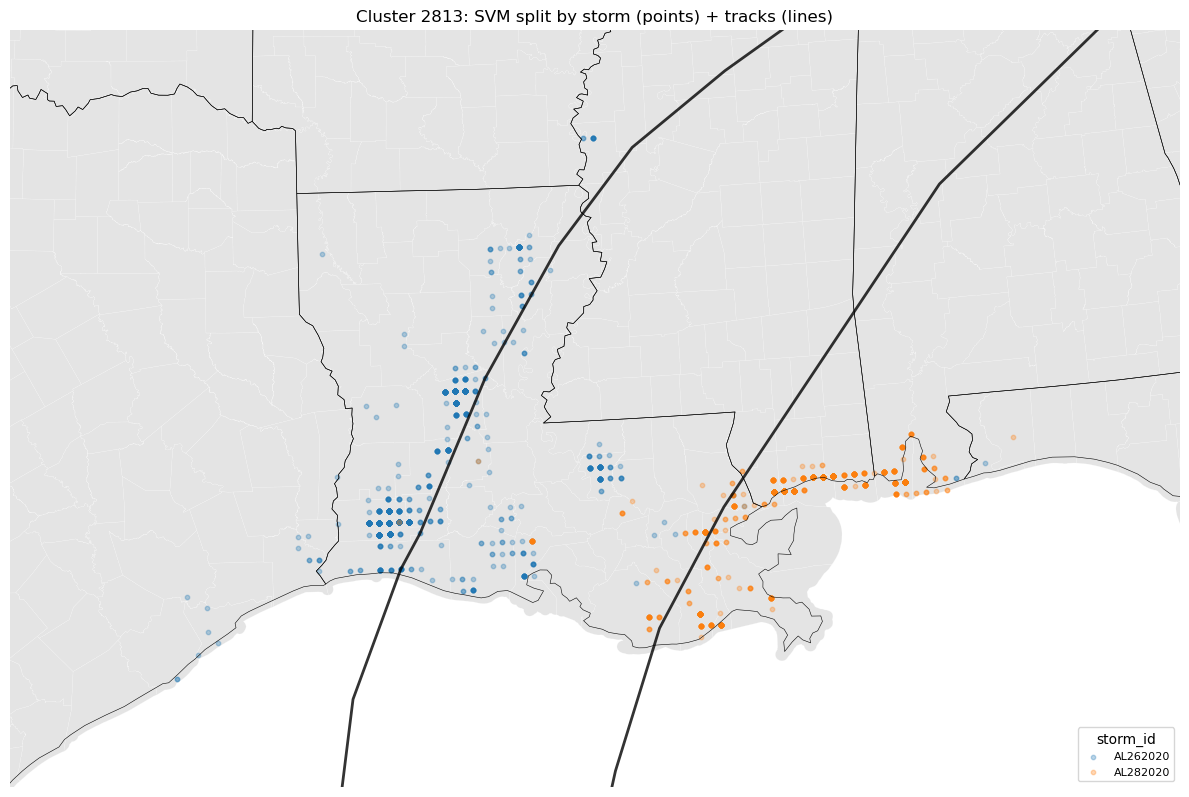

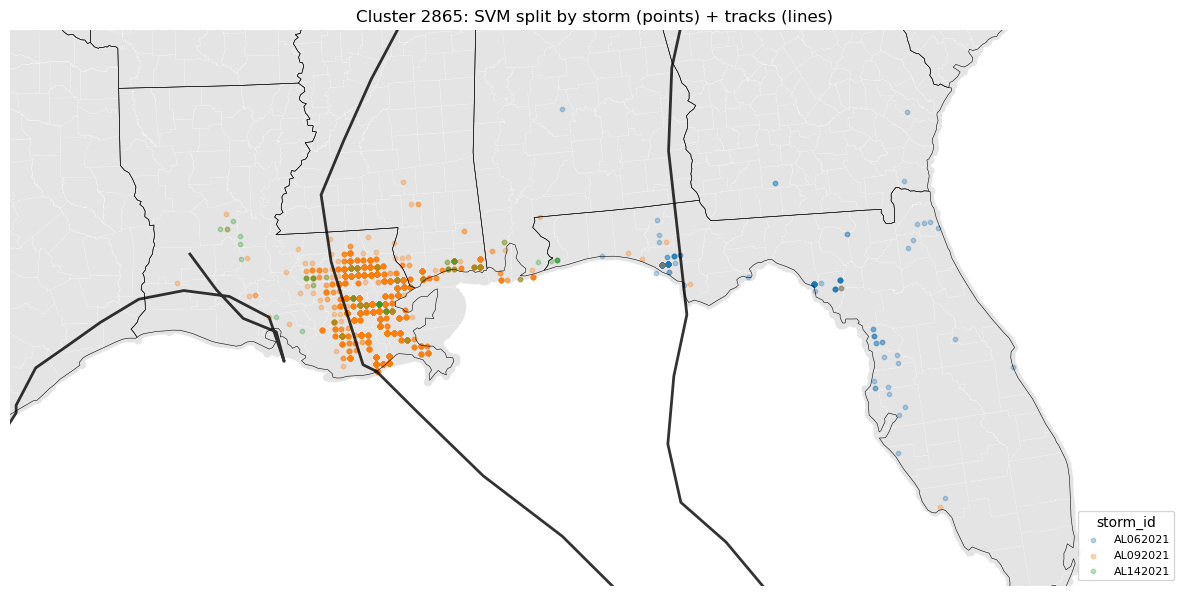

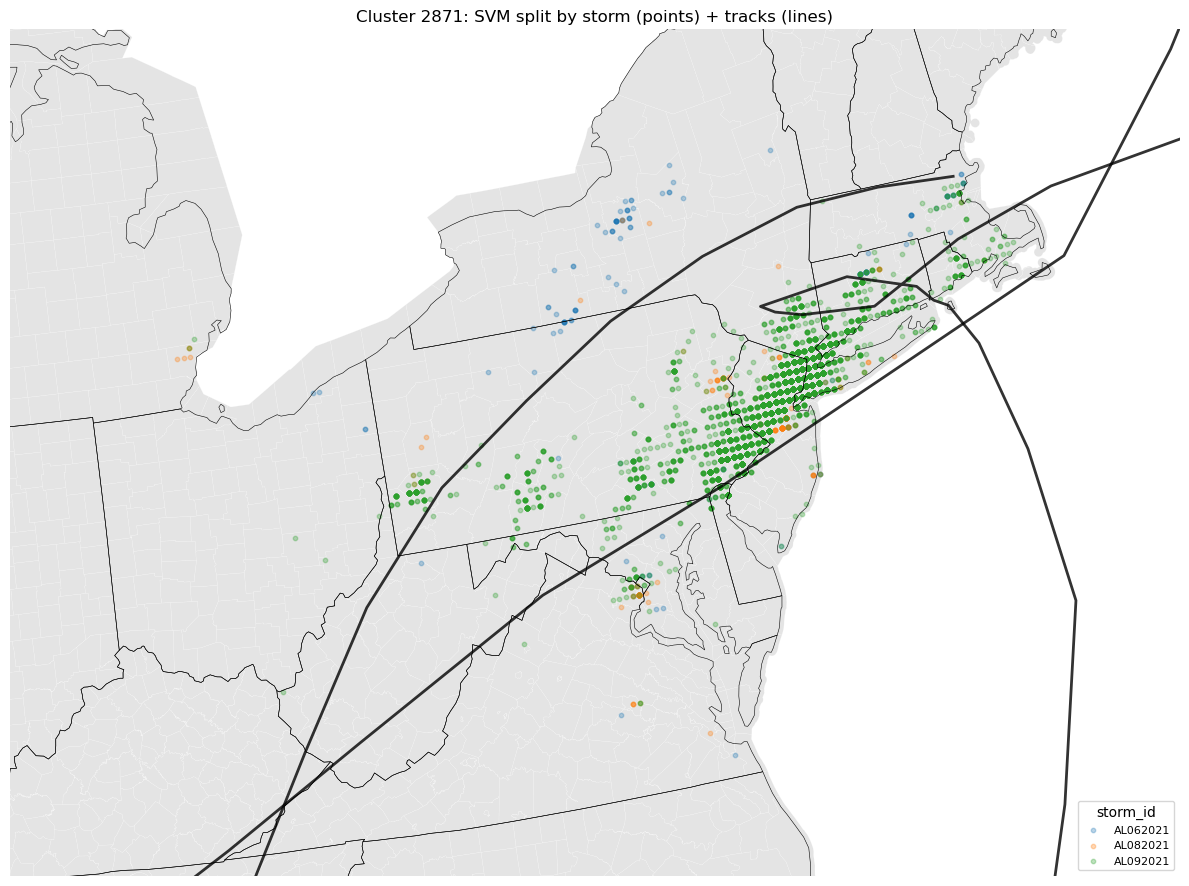

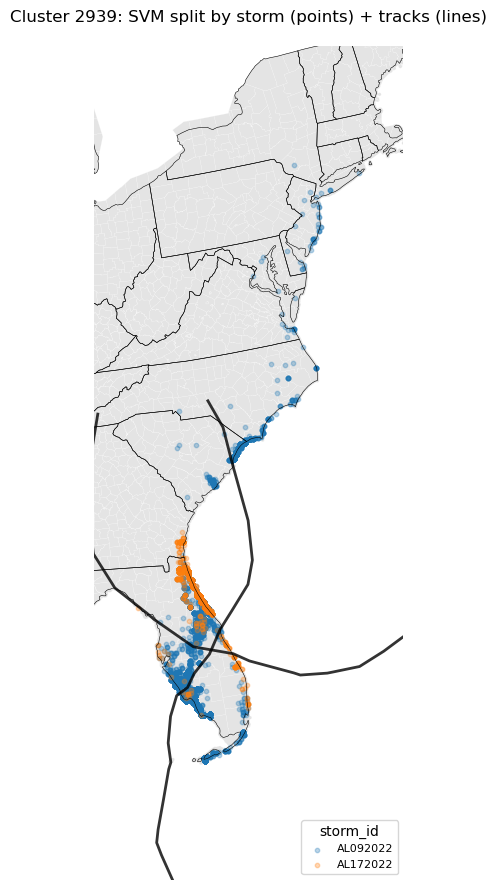

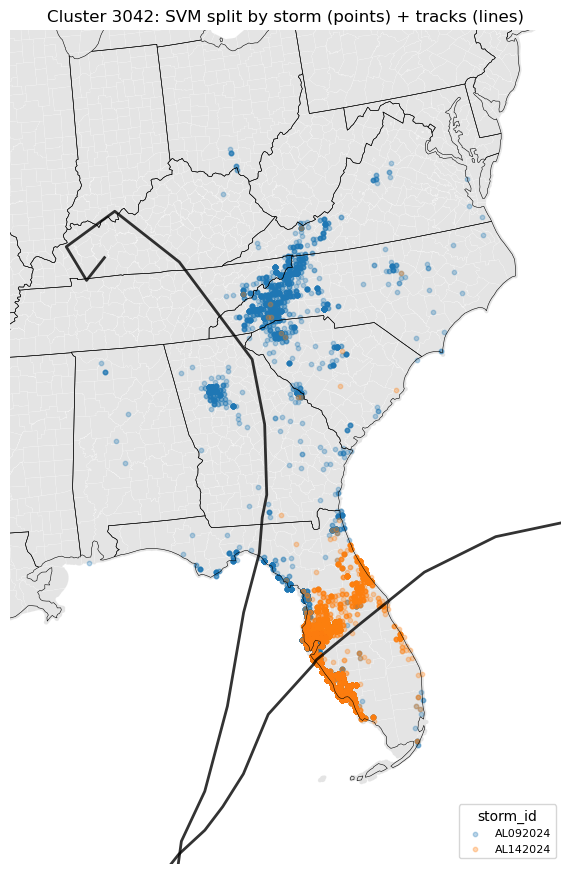

In [16]:
# Per-cluster SVM split & plotting ─────────────────────────────
# Storage for final assignments
assignments = []
if "id" not in clustered_claims.columns:
    clustered_claims["id"] = np.arange(len(clustered_claims), dtype=np.int64)

for cid in multi_track_clusters:
    claims_sub = clustered_claims.loc[
        clustered_claims[optimal_cluster] == cid,
        ["id", optimal_cluster, "dateOfLoss", "latitude", "longitude"]
    ].dropna().copy()

    if claims_sub.empty:
        continue

    # Candidate matches for this cluster
    msub = valid_matches.loc[valid_matches["cluster_id"] == cid].copy()
    cand_storms = sorted(msub["storm_id"].unique().tolist())
    if len(cand_storms) < 2:
        continue

    # Seed labels from nearest fix (space–time score)
    seeds = seed_labels_by_closest_fix(msub)

    # Build features and align with seeds
    # Create stable claim keys to join seeds back
    claims_sub["claim_key"] = list(zip(claims_sub["dateOfLoss"].values,
                                       claims_sub["latitude"].round(5).values,
                                       claims_sub["longitude"].round(5).values))
    y_seed = claims_sub["claim_key"].map(seeds)  # storm_id or NaN

    # Inside the per-cluster loop, replacing your fallback
    if y_seed.isna().any():
        tmin = claims_sub["dateOfLoss"].min() - pd.Timedelta(days=5)
        tmax = claims_sub["dateOfLoss"].max() + pd.Timedelta(days=5)
        fixes = hurdat_ll.loc[
            (hurdat_ll["storm_id"].isin(cand_storms)) &
            (hurdat_ll["iso_time"].between(tmin, tmax))
        ].copy()
    
        # Project once for distances
        fixes_proj = fixes.to_crs(CRS_EQD)
        storm_fix_groups = {sid: df for sid, df in fixes_proj.groupby("storm_id")}
        storm_time_groups = {sid: fixes.loc[fixes["storm_id"]==sid, "iso_time"].values
                             for sid in cand_storms}
    
        SPEED_KMH = 30.0  # tune 25–40
    
        def nearest_storm_spacetime(row):
            p = gpd.GeoSeries([Point(row["longitude"], row["latitude"])], crs=CRS_LL)\
                  .to_crs(CRS_EQD).iloc[0]
            t = row["dateOfLoss"].to_datetime64()
    
            best_sid, best_score = None, np.inf
            for sid in cand_storms:
                fp = storm_fix_groups.get(sid)
                if fp is None or fp.empty:
                    continue
                # Find the fix closest in time to the claim
                times = storm_time_groups[sid]
                i = np.argmin(np.abs(times - t))
                # Spatial distance to that fix
                d_space = fp.geometry.iloc[i].distance(p) / 1000.0  # meters -> km
                # Time penalty in km
                dt_h = abs((pd.Timestamp(times[i]).to_pydatetime() - row["dateOfLoss"]).total_seconds())/3600.0
                score = d_space + dt_h * SPEED_KMH
                if score < best_score:
                    best_score, best_sid = score, sid
            return best_sid
    
        y_seed = y_seed.fillna(claims_sub.apply(nearest_storm_spacetime, axis=1))

    X, gdf_claims_proj = make_features(claims_sub, speed_kmh=30.0)
    feat_cols = ["x_km","y_km","t_km"]
    
    clf = make_pipeline(
        StandardScaler(with_mean=True, with_std=False),  # center but DON'T rescale away weights
        SVC(kernel="rbf", C=1.0, gamma="scale", class_weight="balanced", probability=True, random_state=42)
    )
    clf.fit(X[feat_cols], y_seed)

    # Predict assignments + confidence
    y_pred = clf.predict(X)
    proba = clf.predict_proba(X).max(axis=1)

    claims_sub["svm_storm_id"] = y_pred
    claims_sub["svm_confidence"] = proba
    assignments.append(
        claims_sub[["id", optimal_cluster, "dateOfLoss", "latitude", "longitude"]]
            .assign(svm_storm_id=y_pred, svm_confidence=proba)
            .copy()
    )

    # ── Plot the outcome for this cluster ────────────────────────────
    # Build a per-storm color map
    uniq_sids = sorted(pd.unique(y_pred))
    cmap = plt.get_cmap("tab10")
    colors = {sid: cmap(i % 10) for i, sid in enumerate(uniq_sids)}

    fig, ax = plt.subplots(1, 1, figsize=(12, 9))

    # Basemaps
    if gdf_counties is not None:
        gdf_counties.plot(ax=ax, color='lightgray', edgecolor='white', linewidth=0.2, alpha=0.6)
    if gdf_states is not None:
        gdf_states.boundary.plot(ax=ax, color='black', linewidth=0.4)

    # Plot track lines for candidate storms
    gdf_tracks.loc[gdf_tracks["storm_id"].isin(cand_storms)].plot(
        ax=ax, linewidth=2.0, alpha=0.8,
        color=gdf_tracks["storm_id"].map(lambda sid: colors.get(sid, "k"))
    )

    # Plot claims colored by predicted storm
    for sid in uniq_sids:
        pts = gdf_claims_proj.loc[claims_sub["svm_storm_id"] == sid]
        pts.plot(ax=ax, markersize=POINT_SIZE, alpha = 0.3, color=colors[sid], label=f"{sid}")

    # Extent: pad around points
    if not gdf_claims_proj.empty:
        xmin, ymin, xmax, ymax = gdf_claims_proj.total_bounds
        dx = (xmax - xmin) * 0.2 if xmax > xmin else 1e5
        dy = (ymax - ymin) * 0.2 if ymax > ymin else 1e5
        ax.set_xlim(xmin - dx, xmax + dx)
        ax.set_ylim(ymin - dy, ymax + dy)

    ax.set_title(f"Cluster {cid}: SVM split by storm (points) + tracks (lines)")
    ax.axis("off")
    ax.legend(title="storm_id", loc="lower right", fontsize=8)
    plt.tight_layout()
    plt.show()

In [17]:
if assignments:
    assign_all = pd.concat(assignments, ignore_index=True)

    # Build ID→label maps (tiny Series, just a few cols)
    id_to_storm = assign_all.drop_duplicates("id").set_index("id")["svm_storm_id"]
    id_to_conf  = assign_all.drop_duplicates("id").set_index("id")["svm_confidence"]

    # Update only rows in multi-track clusters
    mt_mask = clustered_claims[optimal_cluster].isin(multi_track_clusters)

    clustered_claims.loc[mt_mask, "svm_storm_id"] = (
        clustered_claims.loc[mt_mask, "id"].map(id_to_storm)
    )
    clustered_claims.loc[mt_mask, "svm_confidence"] = (
        clustered_claims.loc[mt_mask, "id"].map(id_to_conf)
    )

    # Optional quick report
    assigned = clustered_claims.loc[mt_mask & clustered_claims["svm_storm_id"].notna()]
    print(f"SVM assignments written for {len(assigned):,} rows across "
          f"{assigned[optimal_cluster].nunique()} multi-track clusters.")
else:
    print("No assignments produced.")

SVM assignments written for 548,446 rows across 22 multi-track clusters.


In [18]:
# Ensure temporal column exists under desired name
if "temporal_cluster_gid" not in clustered_claims.columns:
    for cand in ["temporal_cluster", "temporal_cluster_id"]:
        if cand in clustered_claims.columns:
            clustered_claims["temporal_cluster_gid"] = clustered_claims[cand]
            break
    clustered_claims.setdefault("temporal_cluster_gid", pd.NA)

# Build split id only where assigned
has_assign = clustered_claims["svm_storm_id"].notna()
clustered_claims.loc[has_assign, "split_cluster_id"] = (
    clustered_claims.loc[has_assign, "st_cluster_final_gid"].astype(str)
    + "_"
    + clustered_claims.loc[has_assign, "svm_storm_id"].astype(str)
)

cols_out = [
    "id", "dateOfLoss", "longitude", "latitude",
    "temporal_cluster_gid", "st_cluster_final_gid", "split_cluster_id"
]

subset_df = (
    clustered_claims.loc[has_assign, cols_out]
    .sort_values(["st_cluster_final_gid", "split_cluster_id", "dateOfLoss"])
    .copy()
)

subset_df.to_csv("hurr_cluster_split_subset1.csv", index=False)
print(f"Exported {len(subset_df):,} rows to hurr_cluster_split_subset.csv")

Exported 548,446 rows to hurr_cluster_split_subset.csv
